In [57]:
import numpy as np
import torch
import math
from assignment1.cs231n.data_utils import get_CIFAR10_data

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


In [9]:
num_classes = len(np.unique(data["y_train"]))
num_classes

10

In [21]:
class PytorchModel(torch.nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        input_dim = 32*32*3
        hidden_dim = 100
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim, bias=True)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.act1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.act2 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(hidden_dim, num_classes, bias=True)
        
        torch.nn.init.kaiming_normal_(self.fc1.weight, mode="fan_in", nonlinearity="relu")
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        torch.nn.init.zeros_(self.fc2.bias)
        torch.nn.init.xavier_normal_(self.fc3.weight)
        torch.nn.init.zeros_(self.fc3.bias)
        
    
    def forward(self, x):
        out = self.act1(self.bn1(self.fc1(x)))
        out = self.act2(self.bn2(self.fc2(out)))
        out = self.fc3(out)
        return out

def pytorch_sgd(parameters, lr):
    for param in parameters:
        param

In [59]:
pytorch_model = PytorchModel()

learning_rate = 1e-3
batch_size = 100
num_epochs = 10

criterion = torch.nn.CrossEntropyLoss(reduction="mean")
sgd_optimizer = torch.optim.SGD(pytorch_model.parameters(), lr=learning_rate)

global_iter = 0
num_iter_per_epoch = math.ceil(len(data["X_train"]) / batch_size)
total_iters = num_epochs * num_iter_per_epoch

loss_history = []
for epoch in range(num_epochs):
    for idx in range(0, len(data["X_train"]), batch_size):
        x_train = data["X_train"][idx:idx+batch_size]
        x_train = torch.from_numpy(x_train.reshape(len(x_train), -1)).to(dtype=torch.float32)
        y_train = torch.from_numpy(data["y_train"][idx:idx+batch_size]).to(dtype=torch.int64)
        
        y_pred = pytorch_model(x_train)
        loss = criterion(y_pred, y_train)
        
        loss.backward()
        sgd_optimizer.step()
        sgd_optimizer.zero_grad()

        global_iter += 1
        loss_history.append((global_iter, loss.detach().item()))
        if (global_iter + 1) % 100 == 0:
            print(f"[Iter {global_iter+1} / {total_iters}] epoch: {epoch} loss: {loss.detach().item():.3f}")
        

[Iter 100 / 4900] epoch: 0 loss: 2.127
[Iter 200 / 4900] epoch: 0 loss: 2.022
[Iter 300 / 4900] epoch: 0 loss: 2.082
[Iter 400 / 4900] epoch: 0 loss: 1.955
[Iter 500 / 4900] epoch: 1 loss: 1.994
[Iter 600 / 4900] epoch: 1 loss: 1.913
[Iter 700 / 4900] epoch: 1 loss: 1.786
[Iter 800 / 4900] epoch: 1 loss: 1.959
[Iter 900 / 4900] epoch: 1 loss: 1.963
[Iter 1000 / 4900] epoch: 2 loss: 1.941
[Iter 1100 / 4900] epoch: 2 loss: 1.937
[Iter 1200 / 4900] epoch: 2 loss: 1.866
[Iter 1300 / 4900] epoch: 2 loss: 1.944
[Iter 1400 / 4900] epoch: 2 loss: 1.713
[Iter 1500 / 4900] epoch: 3 loss: 1.659
[Iter 1600 / 4900] epoch: 3 loss: 1.634
[Iter 1700 / 4900] epoch: 3 loss: 1.737
[Iter 1800 / 4900] epoch: 3 loss: 1.861
[Iter 1900 / 4900] epoch: 3 loss: 1.713
[Iter 2000 / 4900] epoch: 4 loss: 1.594
[Iter 2100 / 4900] epoch: 4 loss: 1.660
[Iter 2200 / 4900] epoch: 4 loss: 1.691
[Iter 2300 / 4900] epoch: 4 loss: 1.611
[Iter 2400 / 4900] epoch: 4 loss: 1.799
[Iter 2500 / 4900] epoch: 5 loss: 1.754
[Iter 260

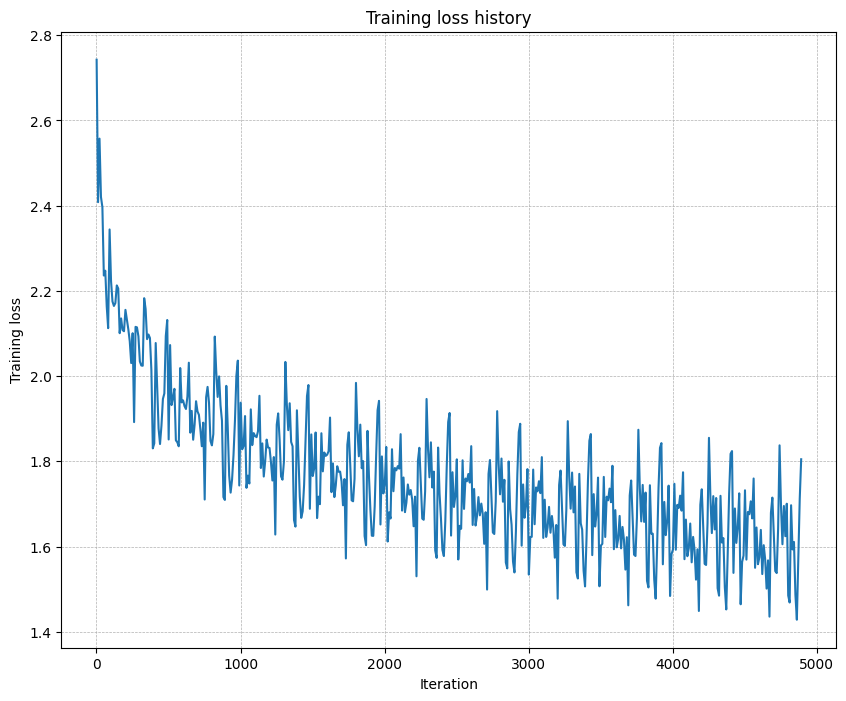

In [68]:
loss_array = np.array(loss_history)
plt.plot(loss_array[::10,0], loss_array[::10,1])
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

In [133]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """Forward pass for batch normalization.
    https://arxiv.org/abs/1502.03167

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7
    implementation of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param["mode"]
    eps = bn_param.get("eps", 1e-5)
    momentum = bn_param.get("momentum", 0.9)

    N, D = x.shape
    running_mean = bn_param.get("running_mean", np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get("running_var", np.zeros(D, dtype=x.dtype))


    sample_mean = np.mean(x, axis=0)  # (D,)
    sample_var = np.var(x, axis=0)

    out, cache = None, None
    if mode == "train":
        x_norm = (x - sample_mean) / np.sqrt(sample_var + eps)
        out = gamma * x_norm + beta

        # running mean and var are only used at test time
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var

        cache = {
            "x_norm": x_norm,
            "gamma": gamma,
            "x_norm_numerator": x - sample_mean,
            "x_norm_denominator": 1 / np.sqrt(sample_var + eps),
        }

    elif mode == "test":
        x_norm = (x - running_mean) / np.sqrt(running_var + eps)
        out = gamma * x_norm + beta
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param["running_mean"] = running_mean
    bn_param["running_var"] = running_var

    return out, cache


def batchnorm_backward(dout, cache):
    """Backward pass for batch normalization.
    https://arxiv.org/abs/1502.03167

    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """    
    x_norm = cache["x_norm"] # (N,D)
    gamma = cache["gamma"]    
    x_norm_numerator = cache["x_norm_numerator"]
    x_norm_denominator = cache["x_norm_denominator"] # 1/denominator


    N = dout.shape[0]
    dbeta = np.sum(dout, axis=0) # (D,)
    dgamma = np.sum(dout * x_norm, axis=0) # (D,)

    d_xnorm = dout * gamma # (N,D) broadcast the gamma
    
    d_var = -0.5 * np.sum(d_xnorm * x_norm_numerator * np.pow(x_norm_denominator, 3), axis=0) # (D,)
    d_mean = - np.sum(d_xnorm * x_norm_denominator, axis=0) - (2/N) * d_var * np.sum(x_norm_numerator, axis=0)

    dx = d_xnorm * x_norm_denominator + (2/N) * d_var * x_norm_numerator + (1/N) * d_mean
    
    return dx, dgamma, dbeta

In [134]:
def linear(x, weight, bias):
    """
    x (N,D1)
    weight (D2,D1)
    bias (D2,)
    """
    output = x @ weight.T + bias
    cache = {
        "x": x,
        "weight": weight,
    }
    return output, cache

def linear_backward(dout, cache):
    """
    dout shape (N,D2)
    """
    dx = dout @ cache["weight"]
    dweight = dout.T @ cache["x"]
    dbias = np.sum(dout, axi=0)
    return dx, dweight, dbias

def relu(x):
    mask = x > 0
    out = x * mask
    cache = {"x": x}
    return out, cache

def relu_backward(dout, cache):
    mask = cache["x"] > 0
    dx = dout * mask
    return dx

def tanh(x):
    out = np.tanh(x)
    return out, {"tanh": tanh}

def tanh_backward(dout, cache):
    dx = dout * (1 - cache["tanh"]**2)
    return dx

  


def cross_entropy_loss(x, y):
    """
    x is shape (N,10)
    y is shape (N,) where each value is in range [0,10)
    """
    score_max = np.max(x, axis=1, keepdims=True) # (N,1)
    scores = x - score_max
    exp = np.exp(scores) # (N,10)
    denom = np.sum(exp, axis=1, keepdims=True)
    softmax = exp / denom
    log = np.log(softmax + 1e-12)
    log_y = log[np.arange(len(x)), y] # (N,)
    avg_loss = - np.sum(log_y) / len(x)
    cache = {"softmax": softmax, "y":y}
    return avg_loss, cache

def cross_entropy_loss_backward(dout, cache):
    """
    dout is a scalar
    """
    softmax = cache["softmax"] # (N,10)
    y = cache["y"]
    
    dx = softmax.copy()
    dx[np.arange(len(y)), y] -= 1
    dx = (1/len(y)) * dout * dx
    return dx



class NumpyModel(torch.nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        input_dim = 32*32*3
        hidden_dim = 100
        self.weight1 = np.random.randn(hidden_dim, input_dim)
        self.bias1 = np.zeros(hidden_dim)
        self.weight2 = np.random.randn(hidden_dim, hidden_dim)
        self.bias2 = np.zeros(hidden_dim)                
        self.weight3 = np.random.randn(num_classes, hidden_dim)
        self.bias3 = np.zeros(num_classes)

        
    
    def forward(self, x, y=None):
        out, cache_fc1 = linear(x, self.weight1, self.bias1)
        out, cache_bn1 = batchnorm(out)
        out, cache_act1 = relu(out)
        
        out, cache_fc2 = linear(out, self.weight2, self.bias2)
        out, cache_bn2 = batchnorm(out)
        out, cache_act2 = tanh(out)
        
        out, cache_fc3 = linear(out, self.weight3, self.bias3)
        
        if y is None:
            return out
        
        loss, cache_loss = cross_entropy_loss(out, y)
        
        # backwards
        grads = {}
        dscores = cross_entropy_loss_backward(1.0, cache_loss)
        dx3, grads["weights3"], grads["bias3"] = linear_backward(dscores, cache_fc3)
        dx_act2 = tanh_backward(dx3, cache_act2)
        dx_bn2 = batchnorm_backward(dx_act2, cache_bn2)
        
        dx2, grads["weights2"], grads["bias2"] = linear_backward(dx_bn2, cache_fc2)
        dx_act1 = relu_backward(dx2, cache_act1)
        dx_bn1 = batchnorm_backward(dx_act1, cache_bn1)
        dx, grads["weights1"], grads["bias1"] = linear_backward(dx_bn1, cache_fc1)
        return loss, grads


In [123]:
sgd_optimizer.zero_grad()
y_pred = pytorch_model(x_train)
y_pred.retain_grad()
loss = criterion(y_pred, y_train)
loss.backward()

In [124]:
np_loss, cache = cross_entropy_loss(y_pred.detach().numpy(), y_train.numpy())
np_loss

np.float32(1.5543506)

In [125]:
criterion(y_pred, y_train)

tensor(1.5544, grad_fn=<NllLossBackward0>)

In [126]:
np_ce_grad = cross_entropy_loss_backward(1.0, cache)

In [127]:
np.allclose(np_ce_grad, y_pred.grad.numpy())

True

In [128]:
np_ce_grad[0]

array([ 3.2954867e-04,  3.8413770e-04,  1.8427303e-03,  5.2825944e-04,
        2.3295067e-03, -9.1859875e-03,  2.6765312e-03,  4.0782688e-04,
        6.0302974e-04,  8.4416119e-05], dtype=float32)

In [129]:
y_pred.grad.numpy()[0]

array([ 3.2954867e-04,  3.8413765e-04,  1.8427303e-03,  5.2825949e-04,
        2.3295069e-03, -9.1859875e-03,  2.6765312e-03,  4.0782682e-04,
        6.0302968e-04,  8.4416126e-05], dtype=float32)